# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

In [43]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from itertools import product
import pandas_profiling

## PART I: Exploratory Data Analysis

In [44]:
bike = pd.read_csv('hour.csv')


In [45]:
bike.sample(5)

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
2101      2102  2011-04-02       2   0     4  10        0        6   
611        612  2011-01-28       1   0     1  17        0        5   
16173    16174  2012-11-11       4   1    11  15        0        0   
15288    15289  2012-10-04       4   1    10   5        0        4   
280        281  2011-01-13       1   0     1   3        0        4   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
2101            0           2  0.36  0.3485  0.57     0.1642      41   
611             1           1  0.24  0.2424  0.75     0.1343       2   
16173           0           1  0.56  0.5303  0.37     0.2239     304   
15288           1           3  0.64  0.5758  0.89     0.1045       2   
280             1           1  0.14  0.1212  0.50     0.3284       0   

       registered  cnt  
2101          113  154  
611           147  149  
16173         420  724  
15288          37   39  
280             3    3

In [46]:
profile = pandas_profiling.ProfileReport(bike)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [48]:
bike2 = bike

In [49]:
from datetime import datetime
# convert the date column to a float
bike2['dteday'] = bike2['dteday'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").timestamp())

print(bike2)

       instant        dteday  season  yr  mnth  hr  holiday  weekday  \
0            1  1.293836e+09       1   0     1   0        0        6   
1            2  1.293836e+09       1   0     1   1        0        6   
2            3  1.293836e+09       1   0     1   2        0        6   
3            4  1.293836e+09       1   0     1   3        0        6   
4            5  1.293836e+09       1   0     1   4        0        6   
...        ...           ...     ...  ..   ...  ..      ...      ...   
17374    17375  1.356908e+09       1   1    12  19        0        1   
17375    17376  1.356908e+09       1   1    12  20        0        1   
17376    17377  1.356908e+09       1   1    12  21        0        1   
17377    17378  1.356908e+09       1   1    12  22        0        1   
17378    17379  1.356908e+09       1   1    12  23        0        1   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
0               0           1  0.24  0.2879  0.81     0.0000   

In [50]:
bike2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  float64
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(5), int64(12)
memory usage: 2.3 MB


In [51]:
bike2 = bike2.drop('registered', axis=1)
bike2 = bike2.drop('casual', axis=1)


In [52]:
bike2 = bike2.drop('dteday', axis=1)

In [71]:
bike2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  cnt         17379 non-null  int64  
dtypes: float64(4), int64(10)
memory usage: 1.9 MB


## PART II: Prediction Model

In [53]:
# X = bike2.drop('cnt', axis=1)
# y = bike2['cnt']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a logistic regression model
# log_reg = LogisticRegression()

# # Fit the model on the training data
# log_reg.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = log_reg.predict(X_test)

# # Calculate the mean squared error (MSE) of the predictions
# mse = mean_squared_error(y_test, y_pred)
# print('MSE:', mse)

In [54]:
# from sklearn.ensemble import RandomForestRegressor

# X = bike2.drop('cnt', axis=1)
# y = bike2['cnt']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a random forest regression model
# rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# # Fit the model on the training data
# rf_reg.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = rf_reg.predict(X_test)

# # Calculate the mean squared error (MSE) of the predictions
# mse = mean_squared_error(y_test, y_pred)
# print('MSE:', mse)

MSE: 1646.3239504027617


In [55]:
# from sklearn.svm import SVR

# # Create a support vector regression model
# svr_reg = SVR(kernel='rbf', C=1e3, gamma=0.1)

# # Fit the model on the training data
# svr_reg.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = svr_reg.predict(X_test)

# # Calculate the mean squared error (MSE) of the predictions
# mse = mean_squared_error(y_test, y_pred)
# print('MSE:', mse)

In [74]:
# # Import necessary libraries
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVR

# X = bike2.drop('cnt', axis=1)
# y = bike2['cnt']


# # Load the dataset and split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train and evaluate a linear regression model
# lr_reg = LinearRegression()
# lr_reg.fit(X_train, y_train)
# y_pred = lr_reg.predict(X_test)
# mse_lr = mean_squared_error(y_test, y_pred)

# # Train and evaluate a decision tree regressor
# dt_reg = DecisionTreeRegressor(random_state=42)
# dt_reg.fit(X_train, y_train)
# y_pred = dt_reg.predict(X_test)
# mse_dt = mean_squared_error(y_test, y_pred)

# # Train and evaluate a support vector regressor
# svm_reg = SVR()
# svm_reg.fit(X_train, y_train)
# y_pred = svm_reg.predict(X_test)
# mse_svm = mean_squared_error(y_test, y_pred)

# # Print the mean squared errors for each model
# print("Linear regression MSE:", mse_lr)
# print("Decision tree MSE:", mse_dt)
# print("Support vector machine MSE:", mse_svm)

In [73]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from collections import Counter

X = bike2.drop('cnt', axis=1)
y = bike2['cnt']

# Load the dataset and split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate a gradient boosting regressor
# gb_reg = GradientBoostingRegressor(random_state=42)
# gb_reg.fit(X_train, y_train)
# y_pred = gb_reg.predict(X_test)
# mse_gb = mean_squared_error(y_test, y_pred)
# r2_gb = r2_score(y_test, y_pred)

# Train and evaluate an XGBoost regressor
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
y_pred[y_pred < 0] = 0
mse_xgb = mean_squared_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)

results=Counter(y_pred)
original=Counter(bike2["cnt"])

# Train and evaluate a LightGBM regressor
# lgb_reg = LGBMRegressor(random_state=42)
# lgb_reg.fit(X_train, y_train)
# y_pred = lgb_reg.predict(X_test)
# mse_lgb = mean_squared_error(y_test, y_pred)
# r2_lgb = r2_score(y_test, y_pred)

# Print the mean squared errors for each model
# print("Gradient boosting MSE:", mse_gb)
print("XGBoost MSE:", mse_xgb)
# print("LightGBM MSE:", mse_lgb)

# Print the R-squared metric for each model
# print("Gradient boosting R-squared:", r2_gb)
print("XGBoost R-squared:", r2_xgb)
# print("LightGBM R-squared:", r2_lgb)

XGBoost MSE: 1357.772467062874
XGBoost R-squared: 0.9571212749256266


Number of rental Bikes  Count
0                 426.415344      1
1                 111.334808      1
2                   9.764328      1
3                 532.307007      1
4                  12.759582      1
...                      ...    ...
3467               10.316795      1
3468               72.290932      1
3469               86.913185      1
3470              351.679810      1
3471              229.991821      1

[3472 rows x 2 columns]

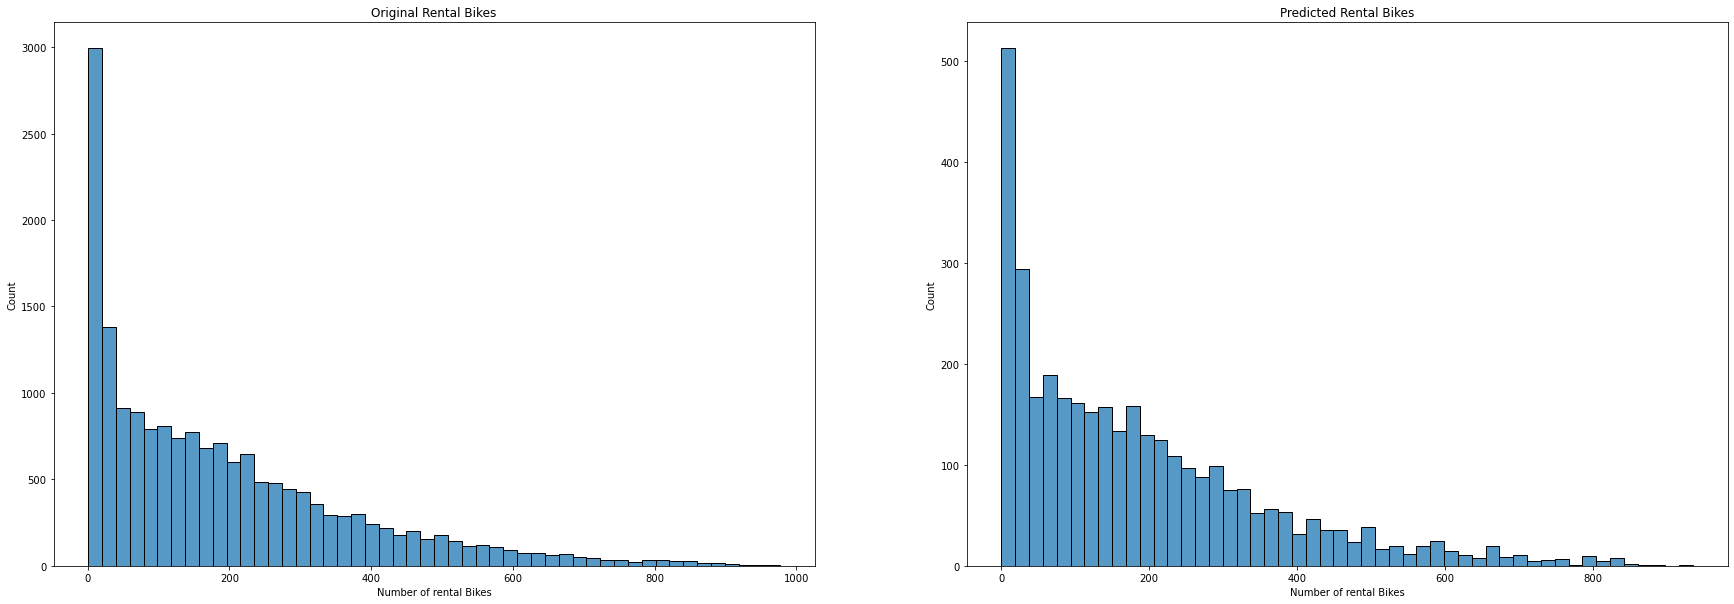

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.DataFrame(list(results.items()), columns=['Number of rental Bikes', 'Count'])
original = pd.DataFrame(list(original.items()), columns=['Number of rental Bikes', 'Count'])

fig, axs = plt.subplots(ncols=2, figsize=(30, 10))

sns.histplot(original, x='Number of rental Bikes', bins=50, weights='Count', ax=axs[0])
axs[0].set(xlabel='Number of rental Bikes', ylabel='Count', title='Original Rental Bikes')

sns.histplot(results, x='Number of rental Bikes', bins=50, weights='Count', ax=axs[1])
axs[1].set(xlabel='Number of rental Bikes', ylabel='Count', title='Predicted Rental Bikes')

plt.show()

## PART III: Streamlit dashboard